In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing useful libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras

In [3]:
# Reading in the data
review_df = pd.read_csv('/content/drive/MyDrive/olist_order_reviews_dataset.csv')
review_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
# Preprocessing the reviews dataset
review_data_title = review_df['review_comment_title']
review_data = review_df.drop(['review_comment_title'],axis=1)

# Dropping NaN values
review_data  = review_data.dropna()
review_data_title = review_data_title.dropna()

# Resetting the reviews index and visualizing the data
review_data = review_data.reset_index(drop=True)
review_data_title = review_data_title.reset_index(drop=True)
review_data.shape


(41753, 6)


This would be a supervised learning case so we would have to create a new column representing sentiment score (1 or 0). 1 is for positive words and 0, for negative words. We would exclude the 3-point review score as that represents neutral and include '1 and 2' review scores as negative words and '4 and 5' review scores for positive words.

In [5]:
# Mapping the ratings
review_data['Sentiment_rating'] = np.where(review_data.review_score > 3,1,0)

# Removing neutral reviews 
review_data = review_data[review_data.review_score != 3]

# Printing the counts of each class
review_data['Sentiment_rating'].value_counts()

1    26680
0    11408
Name: Sentiment_rating, dtype: int64

In [6]:
review_data.shape

(38088, 7)

In [7]:
review_data['Sentiment_rating'].unique()

array([1, 0])

In [8]:
review_data.groupby('Sentiment_rating').nunique()

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
Sentiment_rating,,,,,,
0,11271,11386,2,10999,571,11269
1,26525,26603,2,22669,601,26515


In [9]:
# Getting rid of stopwords, tokenizing and making the text lowercase
nltk.download('stopwords')
nltk.download('punkt')
comments = []
stop_words = set(stopwords.words('portuguese'))


for words in review_data['review_comment_message']:
    only_letters = re.sub("[^a-zA-Z]", " ",words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    comments.append(' '.join(filtered_result))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#comments

In [10]:
# making the text an array
data = np.array(comments)

In [ ]:
#data

In [11]:
labels = np.array(review_data['Sentiment_rating'])
y = []
for i in range(len(labels)):
    if labels[i] == 0:
        y.append(0)
    if labels[i] == 1:
        y.append(1)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
max_words = 5000
max_len = 200

# Encoding and padding the texts
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
encoded_data = pad_sequences(sequences, maxlen=max_len)
print(encoded_data)

[[   0    0    0 ...    5    3  166]
 [   0    0    0 ...  312   67 4868]
 [   0    0    0 ...  388  113  387]
 ...
 [   0    0    0 ...   25    9   17]
 [   0    0    0 ...  546  482  119]
 [   0    0    0 ...    2 3002 1816]]


In [17]:
labels.shape

(38088, 3)

In [18]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(encoded_data,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

28566 9522 28566 9522


In [19]:
# Building and training a bidirectional LSTM model
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train,y_train, epochs=25,validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/25
891/893 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.8764
Epoch 00001: val_accuracy improved from -inf to 0.91955, saving model to best_model.hdf5
893/893 [==============================] - 19s 21ms/step - loss: 0.2978 - accuracy: 0.8765 - val_loss: 0.2081 - val_accuracy: 0.9196
Epoch 2/25
891/893 [============================>.] - ETA: 0s - loss: 0.2075 - accuracy: 0.9210
Epoch 00002: val_accuracy improved from 0.91955 to 0.92775, saving model to best_model.hdf5
893/893 [==============================] - 18s 20ms/step - loss: 0.2079 - accuracy: 0.9209 - val_loss: 0.1944 - val_accuracy: 0.9277
Epoch 3/25
893/893 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.9262
Epoch 00003: val_accuracy did not improve from 0.92775
893/893 [==============================] - 18s 20ms/step - loss: 0.1949 - accuracy: 0.9262 - val_loss: 0.1922 - val_accuracy: 0.9277
Epoch 4/25
892/893 [============================>.] - ETA: 0s - loss: 0.1881 

In [22]:
# model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 40)           200000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 123       
Total params: 209,883
Trainable params: 209,883
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
#Loading the best model obtained during training
best_model = keras.models.load_model("best_model.hdf5")

In [21]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc) 

298/298 - 2s - loss: 0.1850 - accuracy: 0.9340
Model accuracy:  0.9340474605560303


In [29]:
predictions = best_model.predict(X_test)

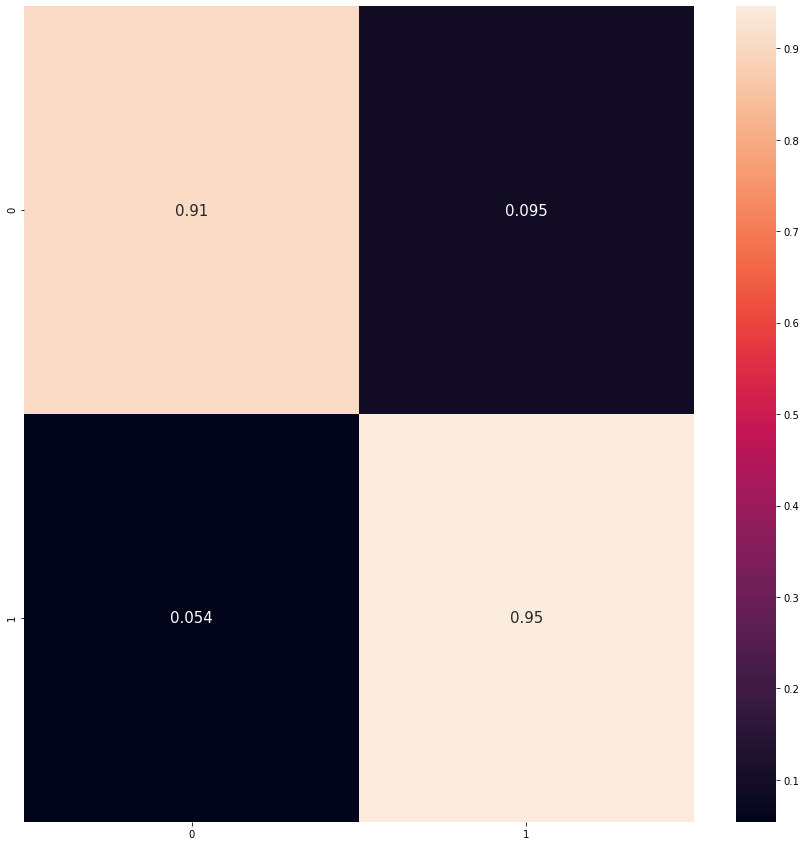

In [30]:
# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
co_matrix = pd.DataFrame(matrix, index = [0,1],columns = [0,1])
co_matrix = co_matrix.astype('float') / co_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(co_matrix, annot=True, annot_kws={"size": 15})
# We can see that the model produced a fairly good score

Running some sample and making predictions;

In [26]:
text_sample = ["as mercadorias foram entregues com atraso"] # Meaning - the goods were delivered late
data1 = np.array(text_sample)
sequences = tokenizer.texts_to_sequences(data1)
text1 = pad_sequences(sequences, maxlen=max_len)
pred = (best_model.predict_classes(text1)>0.5).astype("int64").item()
print(pred) # classified correctly as negative

0


In [27]:
text_sample = ["agradeço a entrega rápida. obrigado"] # Meaning - i appreciate the quick delivery.thanks
data1 = np.array(text_sample)
sequences = tokenizer.texts_to_sequences(data1)
text1 = pad_sequences(sequences, maxlen=max_len)
pred = (best_model.predict_classes(text1)>0.5).astype("int64").item()
print(pred) # classified correctly as positive

1
